In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.dates as mdates

In [ ]:
pip install "numpy<2"

In [ ]:
import numpy as np

# Weekday load simulation

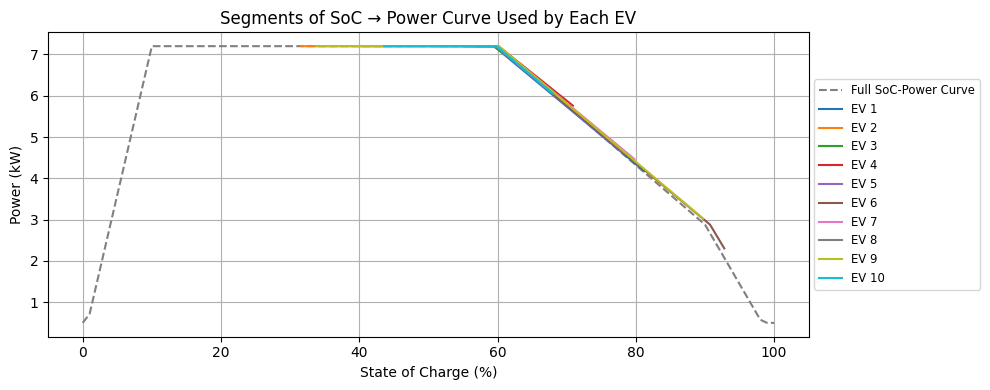

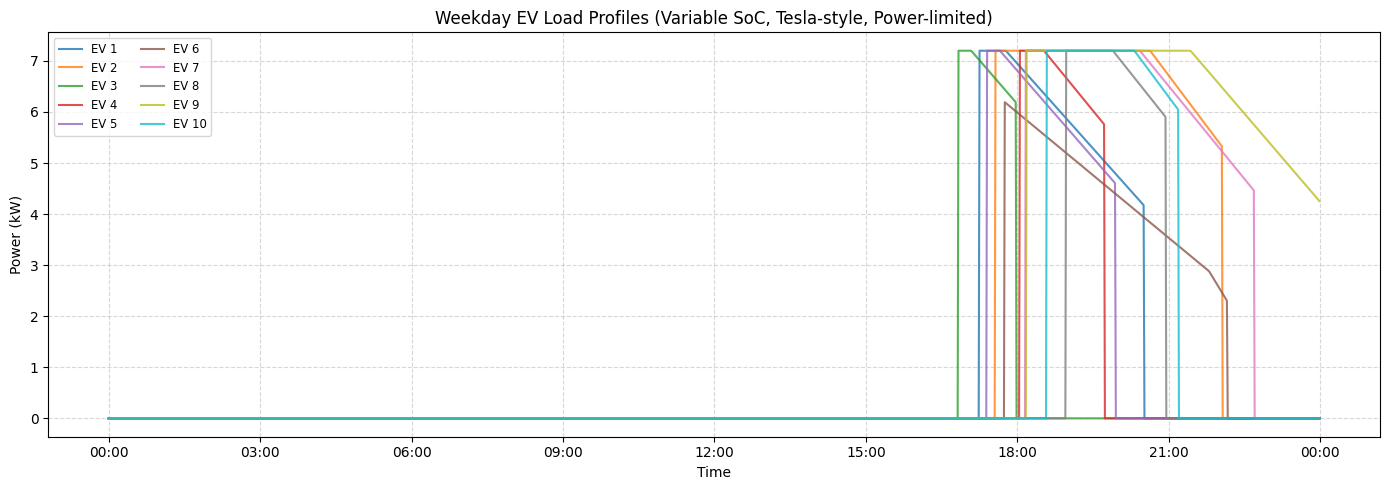

In [16]:
# Settings
n_evs = 10
total_minutes = 1440  # one day
battery_capacity_kWh = 75 # typical for Tesla Model Y or similar
max_power = 7.2  # kW Maximum charging power for home AC charging — 7.2 kW (single-phase, common in UK homes).

# Time index
time_index = pd.date_range(start='00:00', periods=total_minutes, freq='1min') # Creates a DatetimeIndex with one timestamp for each minute in the day.
ev_profiles = np.zeros((n_evs, total_minutes)) # Initialises a matrix of zeros to store the load profiles for each EV. Each row = one EV, each column = one minute.

# Base SoC-to-Power curve (Tesla-style)
def soc_to_power_curve(max_power=7.2): # Defines a function that returns the Tesla-style charging power curve as a function of state of charge (SoC).
    soc_points = np.arange(0, 101) / 100 # Creates 101 points from 0% to 100% SoC, expressed as decimals (0.00 to 1.00)
    power_curve = [] # Initialises a list to hold the corresponding charging power at each SoC point.
    for soc in soc_points: # The loop defines a 4-phase charging behavior:
        if soc < 0.1:
            power = max_power * (soc / 0.1) # Phase 1: ramp-up
        elif soc < 0.6:
            power = max_power # Phase 2: constant current
        elif soc < 0.9:
            power = max_power * (1 - (soc - 0.6) / 0.3 * 0.6) # Phase 3: tapering
        else:
            power = max_power * (1 - (soc - 0.9) / 0.1) * 0.4 # Phase 4: top-off
        power_curve.append(max(power, 0.5)) # Prevents power dropping below 0.5 kW
    return soc_points, np.array(power_curve) # Returns the SoC points and their corresponding charging power as a NumPy array.

# Charging profile based on SoC
def charging_profile_from_soc_range(soc_start, soc_end, battery_capacity_kWh, max_power=7.2): # Generates a charging power time-series (1-min resolution) for a specific SoC range.
    soc_curve, power_curve = soc_to_power_curve(max_power=max_power) # Fetches the full SoC-to-power curve.

    # Slice SOC range and interpolate
    soc_mask = (soc_curve >= soc_start) & (soc_curve <= soc_end) # Filters the curve to include only the SoC segment this EV needs to charge through.
    soc_sub = soc_curve[soc_mask] # Extracts the SoC and power values corresponding to the vehicle's charging range.
    power_sub = power_curve[soc_mask]

    x_soc = np.linspace(soc_start, soc_end, len(soc_sub)) # Prepares a linear interpolation function for this slice of the power curve.
    interpolator = interp1d(x_soc, power_sub, kind='linear')
    high_res_soc = np.linspace(soc_start, soc_end, 200) # Upsamples the SoC–power slice to 200 points for higher temporal resolution.
    power_high_res = interpolator(high_res_soc)

    energy_raw = np.sum(power_high_res) * (1/60) # Estimates how much energy this raw profile would deliver (in kWh), assuming 1-min intervals.
    energy_target = battery_capacity_kWh * (soc_end - soc_start) # Calculates how much energy is actually needed for the given SoC gap.

    scale_factor = energy_target / energy_raw # Computes how much to stretch or shrink the profile duration to deliver the correct energy.
    new_length = int(len(power_high_res) * scale_factor)

    x_old = np.linspace(0, 1, len(power_high_res)) # Interpolates the power profile over the new stretched duration to match the energy target.
    x_new = np.linspace(0, 1, new_length)
    power_scaled = interp1d(x_old, power_high_res, kind='linear')(x_new)

    return power_scaled, high_res_soc, power_high_res # Returns the scaled profile (for time-series use), and the raw SoC/power slice (for debug plotting).

# Debug plot: SoC power segments
plt.figure(figsize=(10, 4))
soc_curve_full, power_curve_full = soc_to_power_curve(max_power=max_power)
plt.plot(soc_curve_full * 100, power_curve_full, label='Full SoC-Power Curve', color='gray', linestyle='--')

# Simulation of profiles
for ev in range(n_evs): # Randomises the SoC start and end points for this EV (ensuring at least 10% difference).
    soc_start = np.random.uniform(0.3, 0.7)
    soc_end = np.random.uniform(soc_start + 0.1, 0.95)
    arrival_hour = np.clip(np.random.normal(18, 0.75), 16.5, 21) # Simulates arrival time (mean = 18:00), clipped between 16:30 and 21:00, and converts to minutes.
    start = int(arrival_hour * 60)

    profile, soc_used, p_used = charging_profile_from_soc_range(soc_start, soc_end, battery_capacity_kWh, max_power=max_power) # Generates and assigns the profile to the appropriate time window in the EV matrix.
    end = min(start + len(profile), total_minutes)
    ev_profiles[ev, start:end] = profile[:end - start]

    # Plot which segment of SoC-power curve this EV used
    plt.plot(soc_used * 100, p_used, label=f'EV {ev+1}') # Plots the SoC→power segment used by this EV for visual debugging.

plt.title('Segments of SoC → Power Curve Used by Each EV') # Shows how each EV used only a slice of the full SoC curve depending on their SoC start/end.
plt.xlabel('State of Charge (%)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

# Modelled profiles plotting
plt.figure(figsize=(14, 5))
for i in range(n_evs):
    plt.plot(time_index, ev_profiles[i], label=f'EV {i+1}', alpha=0.8)

plt.title('Weekday EV Load Profiles (Variable SoC, Tesla-style, Power-limited)')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.savefig('EV_profiles_weekday.png', dpi=300)
plt.show()


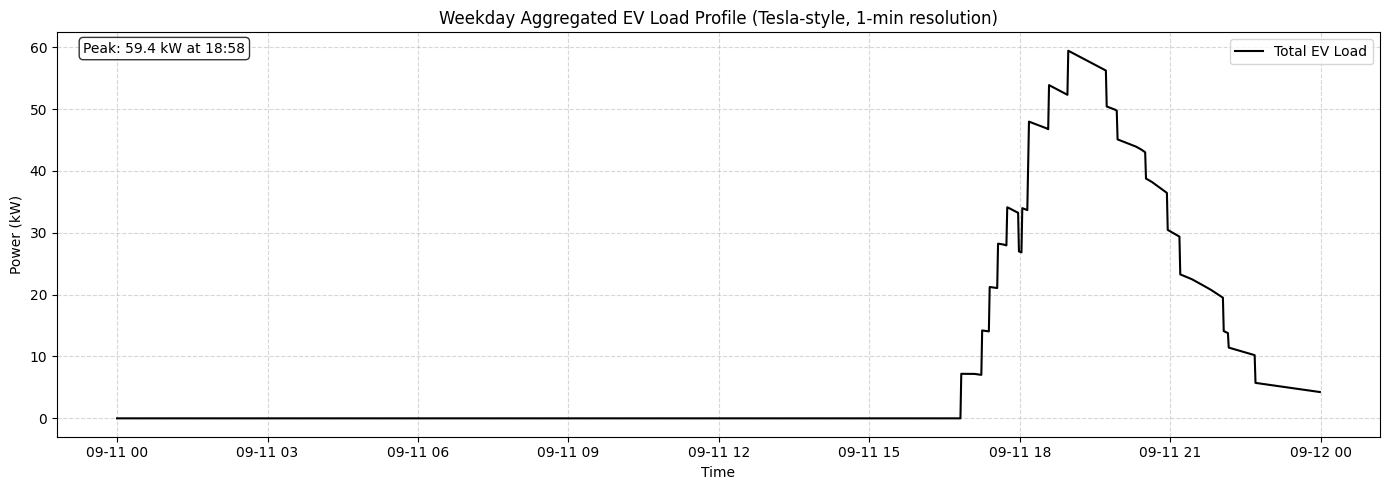

Peak demand: 59.4 kW
Total daily energy: 203.8 kWh


In [17]:
# Aggregated load
aggregate_load = ev_profiles.sum(axis=0)

plt.figure(figsize=(14, 5))
plt.plot(time_index, aggregate_load, label='Total EV Load', color='black')
plt.title('Weekday Aggregated EV Load Profile (Tesla-style, 1-min resolution)')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# adding peak and total energy
peak_load = aggregate_load.max()
peak_time = time_index[aggregate_load.argmax()]
plt.text(0.02, 0.95, f'Peak: {peak_load:.1f} kW at {peak_time.strftime("%H:%M")}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('EV_total_weekday.png', dpi=300)
plt.show()

print(f"Peak demand: {peak_load:.1f} kW")
print(f"Total daily energy: {aggregate_load.sum()/60:.1f} kWh")


In [30]:
# Export to csv
df_evs = pd.DataFrame(ev_profiles, columns=time_index).transpose()
df_evs.columns = [f'EV_{i+1}' for i in range(n_evs)]
df_evs.index.name = 'timestamp'
df_evs.to_csv('EV_profiles_weekday.csv')

# exporting aggregated load
df_total = pd.DataFrame({
    'timestamp': time_index,
    'aggregated_kW': ev_profiles.sum(axis=0)
})
df_total.to_csv('EV_total_weekday.csv', index=False)

print("Exported: 'EV_profiles_weekday.csv' and 'EV_total_weekday.csv.csv'")


Exported: 'EV_profiles_weekday.csv' and 'EV_total_weekday.csv.csv'


# Weekend load simulation

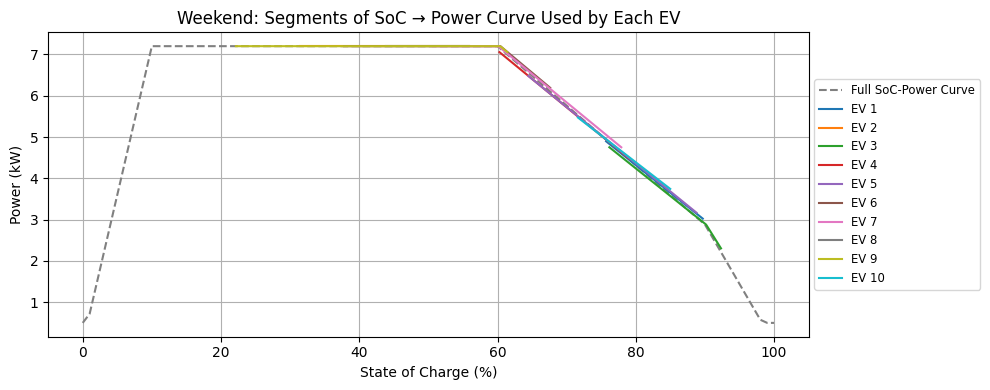

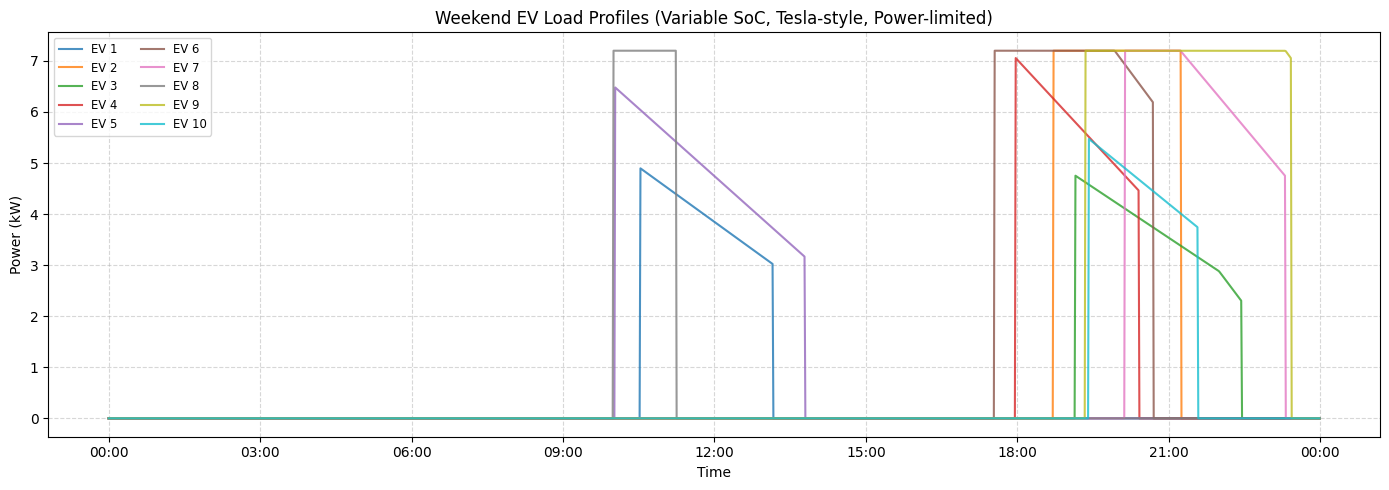

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Settings
n_evs = 10
total_minutes = 1440  # one day
battery_capacity_kWh = 75
max_power = 7.2  # kW

# Time index
time_index_weekend = pd.date_range(start='00:00', periods=total_minutes, freq='1min')
ev_profiles_weekend = np.zeros((n_evs, total_minutes))

# SoC-to-Power curve (Tesla-style)
def soc_to_power_curve(max_power=7.2):
    soc_points = np.arange(0, 101) / 100
    power_curve = []
    for soc in soc_points:
        if soc < 0.1:
            power = max_power * (soc / 0.1)
        elif soc < 0.6:
            power = max_power
        elif soc < 0.9:
            power = max_power * (1 - (soc - 0.6) / 0.3 * 0.6)
        else:
            power = max_power * (1 - (soc - 0.9) / 0.1) * 0.4
        power_curve.append(max(power, 0.5))
    return soc_points, np.array(power_curve)

# Charging profile from SoC range
def charging_profile_from_soc_range(soc_start, soc_end, battery_capacity_kWh, max_power=7.2):
    soc_curve, power_curve = soc_to_power_curve(max_power=max_power)
    soc_mask = (soc_curve >= soc_start) & (soc_curve <= soc_end)
    soc_sub = soc_curve[soc_mask]
    power_sub = power_curve[soc_mask]

    x_soc = np.linspace(soc_start, soc_end, len(soc_sub))
    interpolator = interp1d(x_soc, power_sub, kind='linear')
    high_res_soc = np.linspace(soc_start, soc_end, 200)
    power_high_res = interpolator(high_res_soc)

    energy_raw = np.sum(power_high_res) * (1 / 60)
    energy_target = battery_capacity_kWh * (soc_end - soc_start)
    scale_factor = energy_target / energy_raw
    new_length = int(len(power_high_res) * scale_factor)

    x_old = np.linspace(0, 1, len(power_high_res))
    x_new = np.linspace(0, 1, new_length)
    power_scaled = interp1d(x_old, power_high_res, kind='linear')(x_new)

    return power_scaled, high_res_soc, power_high_res

# Debugging plot: SoC curve segments
plt.figure(figsize=(10, 4))
soc_curve_full, power_curve_full = soc_to_power_curve(max_power=max_power)
plt.plot(soc_curve_full * 100, power_curve_full, label='Full SoC-Power Curve', color='gray', linestyle='--')

# Simulation
for ev in range(n_evs):
    soc_start = np.random.uniform(0.2, 0.8)
    soc_end = np.random.uniform(soc_start + 0.1, 0.95)

    # Weekend arrival: either midday or evening (bimodal)
    arrival_hour = np.random.choice([
        np.random.normal(11, 1),  # midday pattern
        np.random.normal(19, 1)   # evening pattern
    ])
    arrival_hour = np.clip(arrival_hour, 10, 22)  # realistic window
    start = int(arrival_hour * 60)

    profile, soc_used, p_used = charging_profile_from_soc_range(
        soc_start, soc_end, battery_capacity_kWh, max_power
    )
    end = min(start + len(profile), total_minutes)
    ev_profiles_weekend[ev, start:end] = profile[:end - start]

    plt.plot(soc_used * 100, p_used, label=f'EV {ev+1}')

plt.title('Weekend: Segments of SoC → Power Curve Used by Each EV')
plt.xlabel('State of Charge (%)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()

# Final plot
plt.figure(figsize=(14, 5))
for i in range(n_evs):
    plt.plot(time_index_weekend, ev_profiles_weekend[i], label=f'EV {i+1}', alpha=0.8)

plt.title('Weekend EV Load Profiles (Variable SoC, Tesla-style, Power-limited)')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.savefig('EV_profiles_weekend.png', dpi=300)
plt.show()


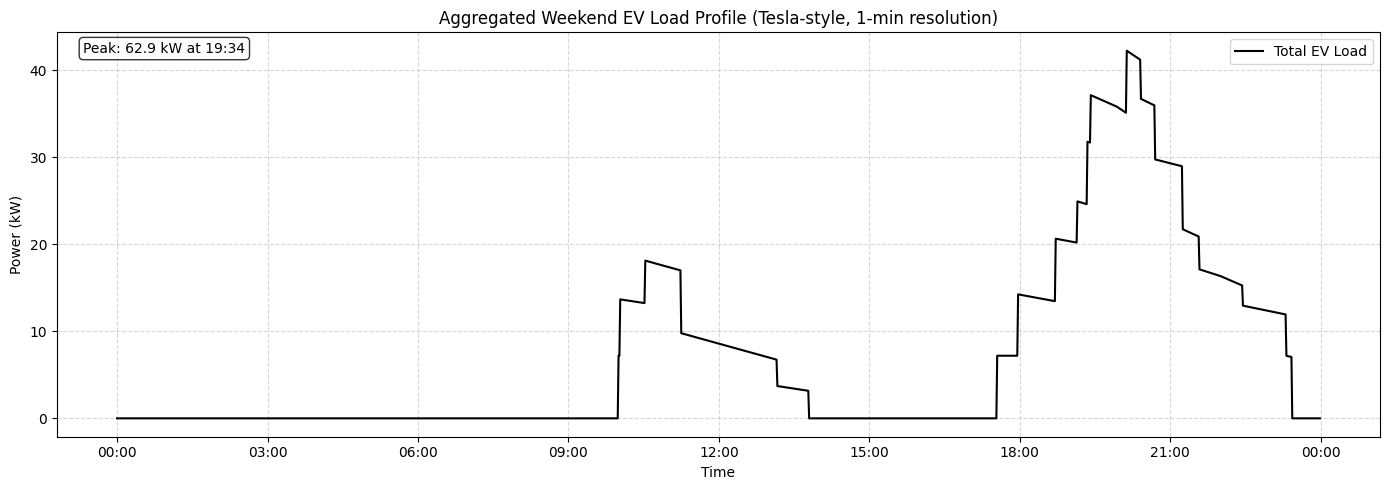

Peak demand: 42.3 kW
Total daily energy: 164.0 kWh


In [33]:
# Total load
aggregate_load_weekend = ev_profiles_weekend.sum(axis=0)

plt.figure(figsize=(14, 5))
plt.plot(time_index_weekend, aggregate_load_weekend, label='Total EV Load', color='black')
plt.title('Aggregated Weekend EV Load Profile (Tesla-style, 1-min resolution)')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
# add some stats
peak_load_weekend = aggregate_load_weekend.max()
peak_time_weekend = time_index_weekend[aggregate_load_weekend.argmax()]
plt.text(0.02, 0.95, f'Peak: {peak_load:.1f} kW at {peak_time.strftime("%H:%M")}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('EV_total_weekend.png', dpi=300)
plt.show()

print(f"Peak demand: {peak_load_weekend:.1f} kW")
print(f"Total daily energy: {aggregate_load_weekend.sum()/60:.1f} kWh")


In [32]:
# Exporting profiles
df_evs_weekend = pd.DataFrame(ev_profiles_weekend, columns=time_index).transpose()
df_evs_weekend.columns = [f'EV_{i+1}' for i in range(n_evs)]
df_evs_weekend.index.name = 'timestamp'
df_evs_weekend.to_csv('EV_profiles_weekend.csv')

# Exporting aggregated load
aggregate_load_weekend = pd.DataFrame({
    'timestamp': time_index_weekend,
    'aggregated_kW': ev_profiles_weekend.sum(axis=0)
})
aggregate_load_weekend.to_csv('EV_total_weekend.csv', index=False)

print(" Exported: 'EV_profiles_weekend.csv' and 'EV_total_weekend.csv'")


 Exported: 'EV_profiles_weekend.csv' and 'EV_total_weekend.csv'
